# Grass growth anomalies

- Weighted means take into account the number of days in each month

In [1]:
import glob
import importlib
import itertools
import os
import sys
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.climag as cplt
from climag import climag_plot
import seaborn as sns
import fiona
import pandas as pd
import datetime

In [2]:
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["HiResIreland"]

In [3]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.drop_vars(
        [
            "bm_gv",
            "bm_gr",
            "bm_dv",
            "bm_dr",
            "age_gv",
            "age_gr",
            "age_dv",
            "age_dr",
            "omd_gv",
            "omd_gr",
            "lai",
            "env",
            "wr",
            "aet",
            "sen_gv",
            "sen_gr",
            "abs_dv",
            "abs_dr",
            "gro",
            "c_bm",
            # "bm",
            "pgro",
            "i_bm",
            "h_bm",
        ]
    )

    return data

In [4]:
# Corine land cover 2018
# pasture only - vectorised (done in QGIS)
pasture = gpd.read_file(
    os.path.join("data", "landcover", "clc-2018-pasture.gpkg"),
    layer="dissolved",
).to_crs(cplt.ITM_EPSG)

In [5]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(
        dataset_dict.values(), combine_attrs="override"
    )
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [10]:
def generate_stats(dataset):
    ds = {}
    # ds_mean ={}
    # ds_max = {}

    for exp, model in itertools.product(exp_list, model_list):
        # auto-rechunking may cause NotImplementedError with object dtype
        # where it will not be able to estimate the size in bytes of object
        # data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds[f"{model}_{exp}"] = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data",
                    "ModVege",
                    dataset,
                    exp,
                    model,
                    f"*{dataset}*{model}*{exp}*.nc",
                )
            ),
            chunks=CHUNKS,
            decode_coords="all",
        )

        # copy CRS
        crs_ds = ds[f"{model}_{exp}"].rio.crs

        # remove spin-up year
        if exp == "historical":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("1976", "2005")
            )
        else:
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("2041", "2070")
            )

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )

        # December data
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(time=ds[f"{model}_{exp}"]["time"].dt.month.isin([12]))

        # assign new coordinates and dimensions
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(exp=exp)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="exp")
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(model=model)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="model")

        # drop unnecessary variables
        ds[f"{model}_{exp}"] = keep_minimal_vars(data=ds[f"{model}_{exp}"])

        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].rio.clip(
            pasture["geometry"].to_crs(ds[f"{model}_{exp}"].rio.crs),
            all_touched=True,
        )

        # weighted mean
        weights = (
            ds[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year")
            / ds[f"{model}_{exp}"]["time"]
            .dt.days_in_month.groupby("time.year")
            .sum()
        )

        # test that the sum of weights for each season is one
        np.testing.assert_allclose(
            weights.groupby("time.year").sum().values,
            np.ones(len(set(weights["year"].values))),
        )

        # calculate the weighted average
        ds[f"{model}_{exp}"] = (
            (ds[f"{model}_{exp}"] * weights)
            .groupby("time.year")
            .sum(dim="time")
        )

        # # max
        # ds_max[f"{model}_{exp}"] = ds[f"{model}_{exp}"].groupby("time.year").max(dim="time")

    # combine data
    ds = combine_datasets(ds, crs_ds)
    # ds_max = combine_datasets(ds_max, crs_ds)

    # ensemble mean
    # ds = ds.mean(dim="model", skipna=True)

    # long-term average
    # ds_lta = ds.mean(dim="year", skipna=True)

    return ds #ds_mean, ds_max  #, ds_lta

In [11]:
hiresireland = generate_stats("HiResIreland")

In [12]:
hiresireland

<xarray.Dataset> Size: 293MB
Dimensions:      (year: 60, model: 4, exp: 3, rlat: 113, rlon: 90)
Coordinates:
  * rlon         (rlon) float64 720B -1.68 -1.645 -1.61 ... 1.365 1.4 1.435
  * rlat         (rlat) float64 904B -1.945 -1.91 -1.875 ... 1.905 1.94 1.975
  * model        (model) <U10 160B 'CNRM-CM5' 'EC-EARTH' ... 'MPI-ESM-LR'
  * year         (year) int64 480B 1976 1977 1978 1979 ... 2067 2068 2069 2070
  * exp          (exp) <U10 120B 'historical' 'rcp45' 'rcp85'
    lon          (rlat, rlon) float32 41kB dask.array<chunksize=(113, 90), meta=np.ndarray>
    lat          (rlat, rlon) float32 41kB dask.array<chunksize=(113, 90), meta=np.ndarray>
    spatial_ref  int64 8B 0
Data variables:
    bm           (year, model, exp, rlat, rlon) float64 59MB dask.array<chunksize=(1, 1, 1, 113, 90), meta=np.ndarray>
    gro          (year, model, exp, rlat, rlon) float64 59MB dask.array<chunksize=(1, 1, 1, 113, 90), meta=np.ndarray>
    i_bm         (year, model, exp, rlat, rlon) float64 59MB dask.array<chunksize=(1, 1, 1, 113, 90), meta=np.ndarray>
    h_bm         (year, model, exp, rlat, rlon) float64 59MB dask.array<chunksize=(1, 1, 1, 113, 90), meta=np.ndarray>
    c_bm         (year, model, exp, rlat, rlon) float64 59MB dask.array<chunksize=(1, 1, 1, 113, 90), meta=np.ndarray>

In [79]:
ds = hiresireland.rio.clip(
    pasture["geometry"].to_crs(hiresireland.rio.crs),
    all_touched=True,
)

In [86]:
df = ds.mean(dim=["rlat", "rlon"]).to_dataframe().dropna().reset_index().drop(columns=["spatial_ref"])

In [87]:
df.head()

,model,year,exp,bm,gro,i_bm,h_bm,c_bm
0,CNRM-CM5,1976,historical,592.320147,0.404723,3287.816394,170.450066,0.082846
1,CNRM-CM5,1977,historical,696.484553,0.079848,2967.021082,30.719180,0.677006
2,CNRM-CM5,1978,historical,685.613975,0.151322,3034.121935,8.065548,0.259412
3,CNRM-CM5,1979,historical,823.039920,0.150739,3151.410164,52.672375,0.343000
4,CNRM-CM5,1980,historical,521.447003,0.522444,2299.919977,66.140569,0.038727


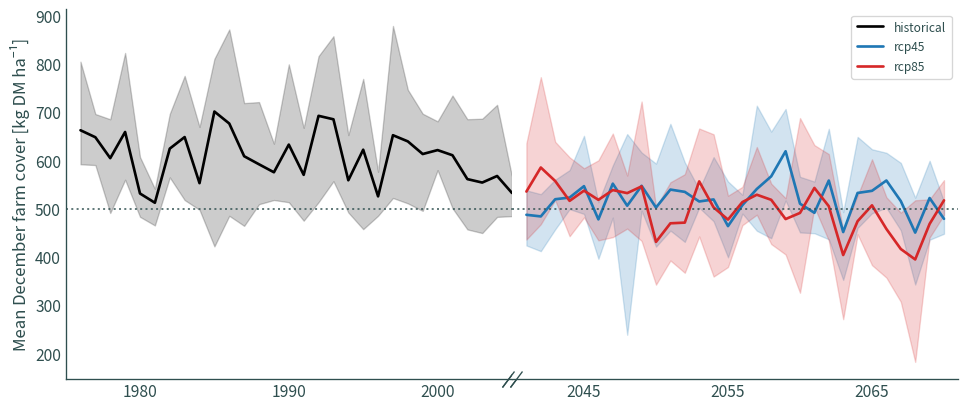

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
fig.subplots_adjust(hspace=0, wspace=0)
sns.lineplot(data=df, x="year", y="bm", hue="exp", palette=sns.color_palette(["black", "tab:blue", "tab:red"]), ax=ax1, legend=False, errorbar=("pi", 100), lw=2)
sns.lineplot(data=df, x="year", y="bm", hue="exp", palette=sns.color_palette(["black", "tab:blue", "tab:red"]), ax=ax2, errorbar=("pi", 100), lw=2)

ax1.set_xlim(1975, 2005)
ax2.set_xlim(2040, 2071)
ax2.spines.left.set_visible(False)
for a in (ax1, ax2):
    a.spines.right.set_visible(False)
    a.spines.top.set_visible(False)
    a.axhline(
        y=500,
        linestyle="dotted",
        color="darkslategrey",
        alpha=0.75,
        # zorder=1,
        # label="Min farm cover",
    )
    a.set_xlabel(None)

d = .75  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12, linestyle="none", color="darkslategrey", mec="darkslategrey", mew=1, clip_on=False)
for a in (ax1, ax2):
    a.plot([0.99], [0], transform=ax1.transAxes, **kwargs)
    a.plot([0.01], [0], transform=ax2.transAxes, **kwargs)

ax1.set_xticks([1980, 1990, 2000])
ax2.set_xticks([2045, 2055, 2065])
ax1.set_ylabel("Mean December farm cover [kg DM ha⁻¹]")

plt.legend(title=None)
# plt.tight_layout()
plt.show()